<a href="https://www.kaggle.com/code/elliep529/cookie-cats-game-analyzing-a-b-testing?scriptVersionId=150809583" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Introduction

* Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment.
* As players progress through the levels of the game, they will occasionally encounter <b>gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress</b>. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.

* <b>The primary objective of the analysis is to consider where the gates should be placed.</b> - Initially the first gate was placed at level 30. In this project,we're going to analyze an AB-test of putting the first gate in Cookie Cats at level 30 or level 40. We will look at the impact on sum of game rounds and player retention.

### Methodology

Data Source: From DataCamp project https://www.datacamp.com/projects/184.

Data Wrangling: Check duplicates, missing data and outliers

Analysis: A/B testing using bootstrap method & hypothesis test

Visualization: Data Visualization is conducted using Python. The following are examined:
1. sum of game rounds: The number of game rounds can serve as an indicator of the extent of time users invest in the game or the impact of the game's level difficulty.
2. retention: Analyze the impact of varying level settings on retention.

### Import packages

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import shapiro, levene, ttest_ind

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mobile-games-ab-testing/cookie_cats.csv


### Read data

In [2]:
data = pd.read_csv('/kaggle/input/mobile-games-ab-testing/cookie_cats.csv')
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


<p>The data is from 90,189 players that installed the game while the AB-test was running. The variables are:</p>
<ul>
<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the test group (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first week after installation
<li><code>retention_1</code> - did the player come back and play 1 day after installing?</li>
<li><code>retention_7</code> - did the player come back and play 7 days after installing?</li>
</ul>
<p>When a player installed the game, he or she was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>. </p>

In [3]:
# Set userid as string
data['userid'] = data['userid'].astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  object
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(1), object(2)
memory usage: 2.2+ MB


### Data rangling

In [4]:
data.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

There is no missing data.

In [5]:
data.groupby('userid').count().sum()

version           90189
sum_gamerounds    90189
retention_1       90189
retention_7       90189
dtype: int64

In [6]:
data.shape

(90189, 5)

There is no repetitive userid.

In [7]:
data.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


Control data & test data have similar number of data.

In [8]:
control_data = data[data['version'] =='gate_30'].reset_index()
test_data = data[data['version'] =='gate_40'].reset_index()

## Data visualization

* Outliers

In [9]:
data['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [10]:
control_data['sum_gamerounds'].describe()

count    44700.000000
mean        52.456264
std        256.716423
min          0.000000
25%          5.000000
50%         17.000000
75%         50.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [11]:
test_data['sum_gamerounds'].describe()

count    45489.000000
mean        51.298776
std        103.294416
min          0.000000
25%          5.000000
50%         16.000000
75%         52.000000
max       2640.000000
Name: sum_gamerounds, dtype: float64

<Axes: title={'center': 'Gate 40 box plot'}>

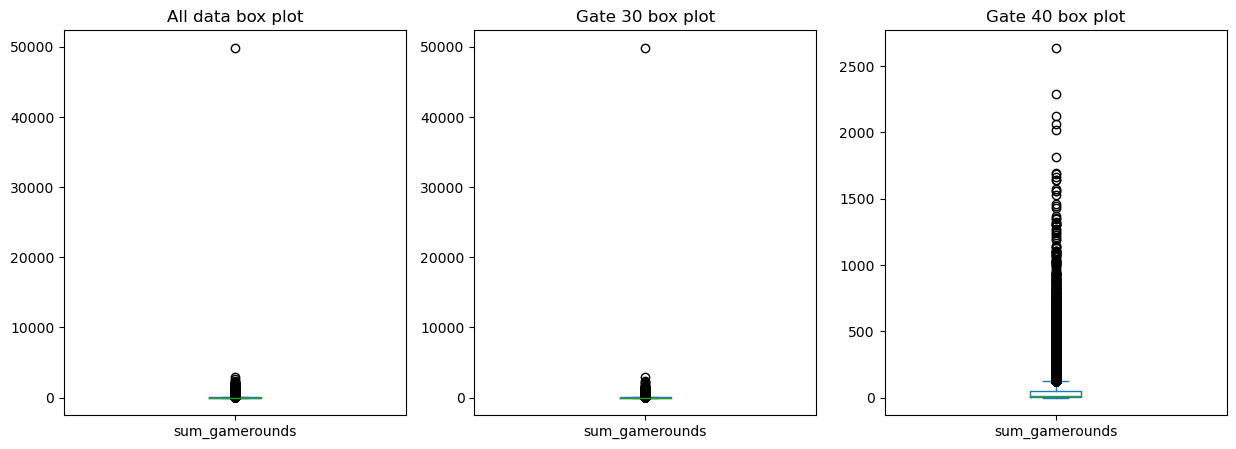

In [12]:
fig, axes = plt.subplots(1, 3)

data['sum_gamerounds'].plot(kind = 'box', ax=axes[0], title = 'All data box plot', figsize = (15,5))
control_data['sum_gamerounds'].plot(kind = 'box', ax=axes[1], title = 'Gate 30 box plot', figsize = (15,5))
test_data['sum_gamerounds'].plot(kind = 'box', ax=axes[2], title = 'Gate 40 box plot', figsize = (15,5))

We can see there are outliers and the gap is really large, especially there's one player in the control group got really hooked and played around 50000 rounds of game within 7 days.

<Axes: title={'center': 'Gate 40 box plot'}>

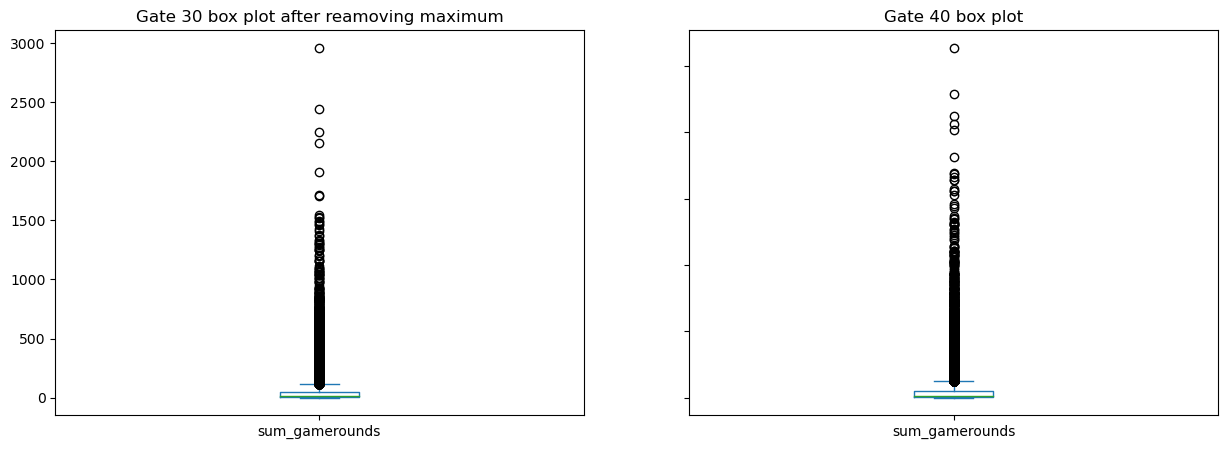

In [13]:
fig, axes = plt.subplots(1, 2)
control_data.loc[control_data['sum_gamerounds'] != control_data['sum_gamerounds'].max()]['sum_gamerounds'].plot(kind = 'box', ax=axes[0], title = 'Gate 30 box plot after reamoving maximum', figsize = (15,5), sharey=True)
test_data['sum_gamerounds'].plot(kind = 'box', ax=axes[1], title = 'Gate 40 box plot', figsize = (15,5), sharey=True)

After removing the maximum outlier in control group, we can see that the data in both control and test group look more similar.

From the box plot, we can also discover that most of the game rounds are pretty small. Now let's take a look at the game rounds:

In [14]:
percentage = pd.DataFrame(data.groupby(by='sum_gamerounds').count()['userid']).reset_index()
percentage['percentage'] = percentage['userid']/(data.shape[0])
percentage.rename(columns = {'userid': 'num_of_user'}, inplace = True)
percentage.loc[0,'acc_percentage'] = percentage.loc[0,'percentage']

for i in range (1, percentage.shape[0]):
    percentage.loc[i,'acc_percentage'] = percentage.loc[i,'percentage'] + percentage.loc[i-1,'acc_percentage']

In [15]:
a = np.array([0, 0.5, 0.75]).reshape(1,-1) 
percentage.iloc[abs(percentage.acc_percentage.to_numpy()[:,None] - a).argmin(0)]

,sum_gamerounds,num_of_user,percentage,acc_percentage
0,0,3994,0.044285,0.044285
16,16,1342,0.014880,0.500216
51,51,359,0.003981,0.751045


From the percentage above, we can see that 50% of users played less than 16 game rounds, and 75% of users played less than 51 rounds.

Text(0, 0.5, 'Number of users')

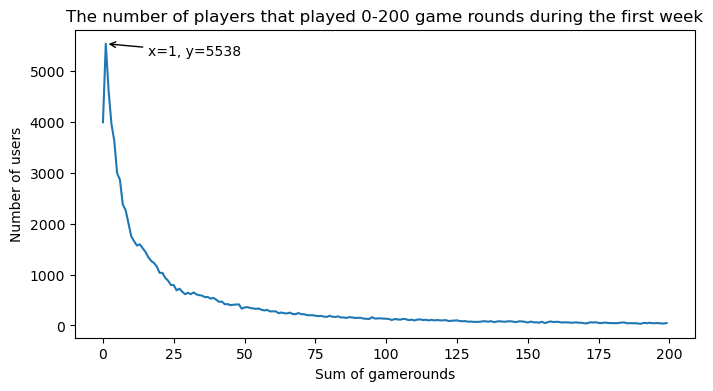

In [16]:
ax = percentage['num_of_user'][:200].plot(kind = 'line', figsize=(8, 4))
xmax = percentage.loc[np.argmax(percentage['num_of_user']), 'sum_gamerounds']
ymax = percentage['num_of_user'].max()
text= "x={}, y={}".format(xmax, ymax)
ax.annotate(text, xy=(xmax, ymax), xytext=(16, 5300), arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

ax.set_title("The number of players that played 0-200 game rounds during the first week")
ax.set_xlabel('Sum of gamerounds')
ax.set_ylabel('Number of users')

The distribution is highly skewed. Approximately 4,000 users did not initiate the game at all, while the maximum number of users, at 5,538, only played a single round of the game.
There is a steady drop after 25 rounds of game play within 7 days.

### A. Game Rounds vs Gate Setting
<b>Purpose: </b> Game rounds can represent how much time the users spent on the game. In order to understand the difference in game rounds that gate setting cause, the examines are conducted as follows.
#### 1. Number of users in differnent combination of retention:
Frist, we can learn about the number of users in each retention groups.

#### <b>Insight:</b>
4.4% of users didn't start playing the game. There could be several reasons for this:
1. Some users downloaded the game but got drawn to other games, causing them to delay starting the application.
2. Upon opening the app, certain players didn't resonate with the user interface, music, design, or the genre of the game, leading them to quit playing.

A significant number of users abandoned the game during the early stages, with 50% of users only completing 16 rounds. 
Possible reasons for this are as follows:
1. Lack of interest in this particular type of game.
2. Disapproval of the user interface, music, or design, which discouraged them from continuing to play.
3. Some users found the game too easy or challenging for their preference.

The company can conduct further analysis on the players who ended the game early to better understand the reasons why a significant number of users did not continue playing the game.

In [17]:
retention_sector = data.groupby(by = ['retention_1', 'retention_7'])
retention_percent = retention_sector[['sum_gamerounds']].count()
retention_percent.rename(columns = {'sum_gamerounds':'num_of_user'}, inplace = True)
retention_percent['percent'] = retention_percent['num_of_user']/retention_percent['num_of_user'].sum()
retention_percent['mean'] = retention_sector.mean()
retention_percent.sort_values(by = 'num_of_user', ascending = False, inplace = True)
retention_percent

/tmp/ipykernel_20/1211362588.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  retention_percent['mean'] = retention_sector.mean()


num_of_user   percent        mean
retention_1 retention_7                                   
False       False              46437  0.514885   11.867283
True        False              26971  0.299050   49.861555
            True               13182  0.146160  187.043089
False       True                3599  0.039905   88.031675

Ranked by user quantity in descending order, the sequence of retention groups is as follows (retention_1, retention_7): (False, False), (True, False), (True, True), (False, True).
* More than half of the users (51%) did not engage with the game within 1 and 7 days after installation, and on average, they played only 12 rounds of the game.
* The second-largest group (30%) includes the user who played the game one day after downloading but did not return 7 days after. On average, they played 50 rounds of game.
* Around 15% of the users kept playing the game, being active on both the 1st and 7th days after installation, and they played an average of 187 rounds.
* As for the remaining 3% of users, they did not play on the 1st day after installation, but they returned on the 7th day and played an average of 88 rounds of the game.

#### 2. Game rounds in differnent combination of retention
Through the following analysis, differences in the number of game rounds among various retention groups can be understood. Based on the result we obtained above, the sequence of retention groups is (retention_1, retention_7): (False, False), (True, False), (True, True), (False, True), based on user quantity in each group in descending order.

In [18]:
def sample_mean(df, col, sample_num):
    mean_lst = []
    for i in range(sample_num):
        mean_lst.append(df.sample(frac=1, replace=True)[col].mean())
    return pd.DataFrame(mean_lst)

Let's take a look at the density plot of each retention group. The graghs below shows that the sequence of game rounds, ordered from highest to lowest, is as follows (True, True), (False, True), (True, False),  (False, False).

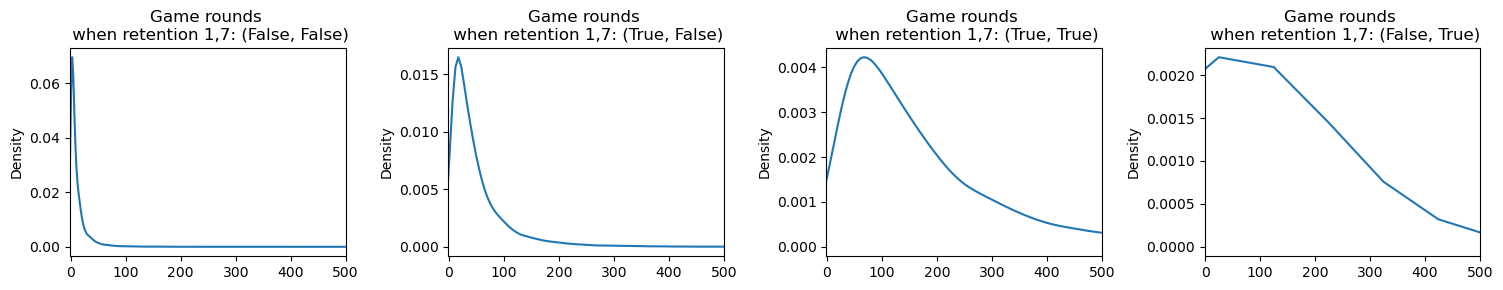

In [19]:
fig, axes = plt.subplots(1,4)
TF_lst = retention_percent.index
ax_lst = [axes[0], axes[1], axes[2], axes[3]]
for i in range(4):
    df = retention_sector.get_group(TF_lst[i])
    df['sum_gamerounds'].plot(kind = 'density', ax = ax_lst[i], xlabel = 'sum of game rounds', figsize = (15,3), title = 'Game rounds \n when retention 1,7: {}'.format(TF_lst[i]))
plt.tight_layout()
plt.setp(axes, xlim=(-1,500))
plt.show()

Then the average of game rounds in each retention group sampling with replacement:

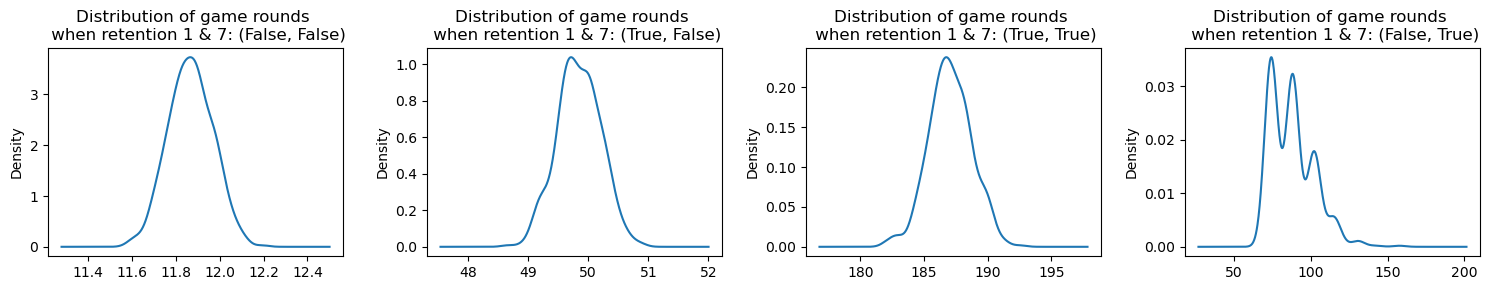

In [20]:
fig, axes = plt.subplots(1,4)
TF_lst = retention_percent.index
ax_lst = [axes[0], axes[1], axes[2], axes[3]]
for i in range(4):
    df = retention_sector.get_group(TF_lst[i])
    TT_df = sample_mean(df, 'sum_gamerounds', 500)
    TT_df.plot(kind = 'density', ax = ax_lst[i], title = 'Distribution of game rounds \n when retention 1 & 7: {}'.format(TF_lst[i]), xlabel = 'sum of game rounds', figsize = (15,3)
              ,legend = False)
plt.tight_layout()
plt.show()

From the density plot above, we can see that, except for the first group, the average number of game rounds for the other three groups is generally greater than 40 rounds, indicating that analyzing the gate design for players in the first group may not be meaningful. 

* The first group either did not open the application or only played a few times, averaging 11.9 rounds, fewer than the gate level setting that we want to compare (level 30 & 40). 
* The 2nd group played an average of around 49.9 rounds of game
* The 3rd group (users who return both on 1 and 7 days after installing), users played around 187.0 rounds of game, which is the highest, with an average of around 187 rounds of game. This may indicate the more frequent the user return to the game, the more game rounds they play. 
* In the density plot of the last group, we can observe significant fluctuations in the average number of game rounds, with peaks occurring around 70 and 90.

<b>Insight: </b>

From the density plot above, we can identify the game rounds differnence between 4 groups. This also provides insights into the time users invest in playing the game. The game rounds for the four groups are ranked in descending order as follows: (true, true), (false, true), (true, false), (false, false). As our primary focus is to compare the impact of gate setting on the game, the average number of levels played by the first group of players is 11.9, which has not yet reached 30 levels, rendering a comparative analysis unfeasible. Conversely, we should further investigate the reasons behind the lower game frequency and lack of game retention for players in the first group.

#### 3. AB test: Game Rounds vs Gate Setting¶
Comparing the different retention groups in the AB test: the analysis above reveals that the players in the first group had too few game rounds, making it difficult to discern differences in gate settings. Therefore, we will proceed with the game round analysis for the <b>remaining three groups<b/>.

#### Methodology: Bootstraping
    A resampling procedure for constructing a sampling distribution using data from a sample.
    
We begin by examining the density distribution of game rounds for different versions within each retention group.

In [21]:
def group_mean(df, col, sample_num):
    mean_lst = []
    for i in range(sample_num):
        mean_lst.append(df.sample(frac=1, replace=True).groupby('version')[col].mean())
    return pd.DataFrame(mean_lst)

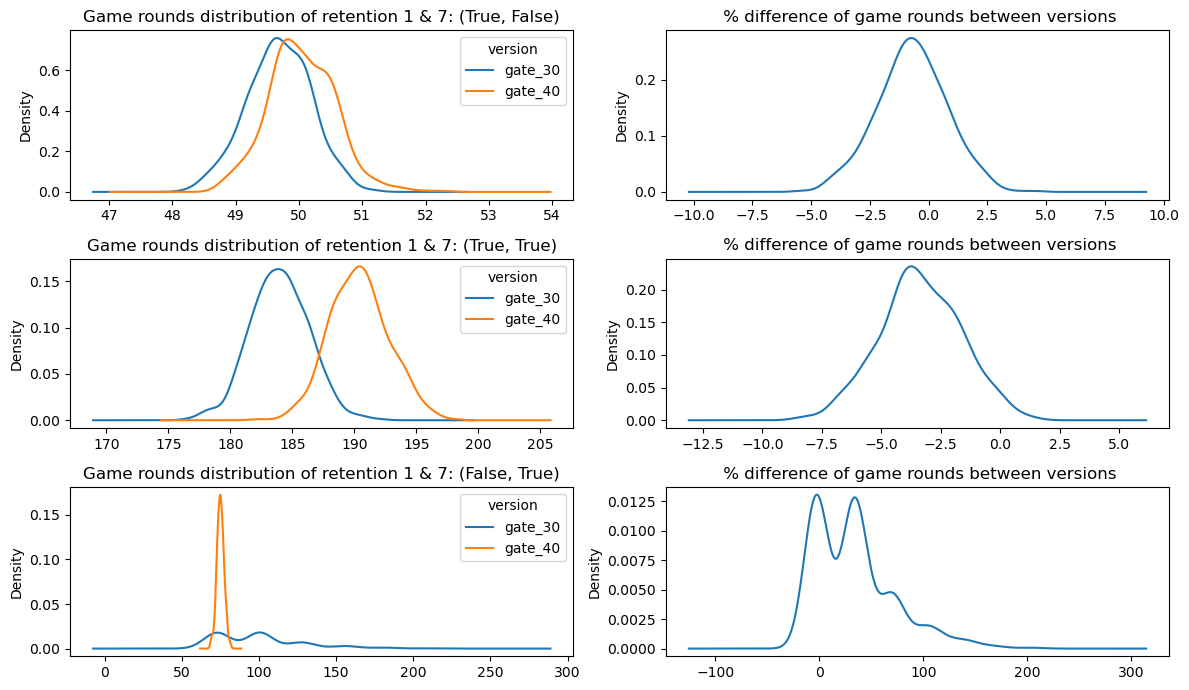

Probability that game rounds was higher when the gate is 30 in retention 1 & 7 is (True, False): 0.306
Probability that game rounds was higher when the gate is 30 in retention 1 & 7 is (True, True): 0.022
Probability that game rounds was higher when the gate is 30 in retention 1 & 7 is (False, True): 0.706


In [22]:
fig, axes = plt.subplots(3, 2)
TF_lst = retention_percent.index
ax_lst = [axes[0,0], axes[1,0], axes[2,0]]
dif_lst = [axes[0,1], axes[1,1], axes[2,1]]
report = []
summary_dict = {'Avg num of users' : [], 'Avg game rounds': []}
for i in range(3):
    df = retention_sector.get_group(TF_lst[i+1])
    TT_df = group_mean(df, 'sum_gamerounds', 500)
    TT_df.plot(kind = 'density', ax = ax_lst[i], title = 'Game rounds distribution of retention 1 & 7: {}'.format(TF_lst[i+1])
               , xlabel = 'sum of game rounds', figsize = (12,7))
    TT_df['diff'] = (TT_df.gate_30-TT_df.gate_40)/TT_df.gate_40*100
    TT_df['diff'].plot(kind = 'density', title = ' % difference of game rounds between versions'
                , ax = dif_lst[i], figsize = (12,7))
    report.append('Probability that game rounds was higher when the gate is 30 in retention 1 & 7 is {}: {}'.format(TF_lst[i+1], (TT_df['diff'] > 0).mean()))
    summary_dict['Avg game rounds'].extend([f'{i:.2f}' for i in TT_df.mean()[:2]])
    
plt.tight_layout()
plt.show()
print("\n".join(report))

* It can be observed that for the first group (retention_1, retention_7) = (True, False), 30% of the game rounds in gate 30 is more than in gate 40.
* Especially in the group with retention_1 = True & retention_7 = True, over 97% of the game rounds in gate 30 are fewer than those in gate 40.
* In the final group, it is observed that the game rounds at gate 30 do not exhibit a significantly normal distribution. Within this group, the game rounds at gate 30 exceeding those at gate 40 is greater than 72%.

In summary, the overall analysis reveals that groups where the level is set at 40 exhibit a higher frequency of gameplay. This might indirectly suggest that placing the game gate at level 40 could potentially lead to players being more inclined to invest time in the game or this approach may help identify players who genuinely love the game, demonstrating their willingness and enthusiasm to invest time in the game.

### B. Retention vs gate setting
Similarly, since the data with retention values of (False, False) holds no analytical significance, the analysis is focused on the remaining three groups with more meaningful data for examination.

<b>Purpose</b>: Understanding the impact of gate setting on players' retention.

#### Methedology:
Bootstraping: Similarly, the utilization of bootstrapping methodology involves iteratively resampling from the dataset. This approach allows us to explore the underlying data distribution and derive valuable insights.

#### 1. Number of users in differnent combination of retention:

Probability that quantity was larger when the gate is 30 : 0    0.428
dtype: float64


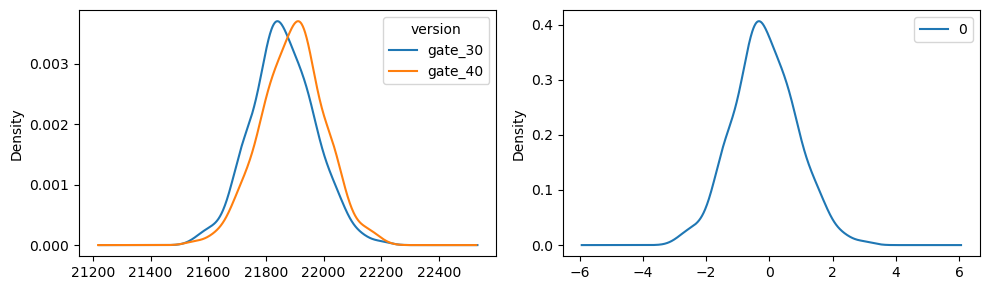

In [23]:
new = data[(data['retention_1'] == True) | (data['retention_7'] == True)]
fig, axes = plt.subplots(1, 2)
size_lst = []
for i in range(500):
     size_lst.append(new.sample(frac=1, replace=True).groupby('version').size())
df = pd.DataFrame(size_lst)
df.plot(kind = 'density', ax = axes[0], figsize = (10,3))

diff_retention = pd.DataFrame([(i[0] - i[1])/i[1]*100 for i in size_lst])
diff_retention.plot(kind = 'density', ax = axes[1], figsize = (10,3))

print('Probability that quantity was larger when the gate is 30 : {}'.format((diff_retention>0).mean()))
plt.tight_layout()
plt.show()

    It can be observed that there is no significant difference in data quantities between different version groups. Employing bootstrapping to observe the distribution and variance of data quantities also serves to verify that the data quantities in the control and test groups exhibit no notable distinctions (falling within the range of -2% to 2%).

#### 2. Retention is "true" between the control and test groups.
Given that we focus on the extent of players' return behavior to the game, with the aim of enhancing retention as much as possible, we can gain preliminary insights by examining the cumulative values of retention.

Probability that retention was higher when the gate is 30 : 0    0.962
dtype: float64


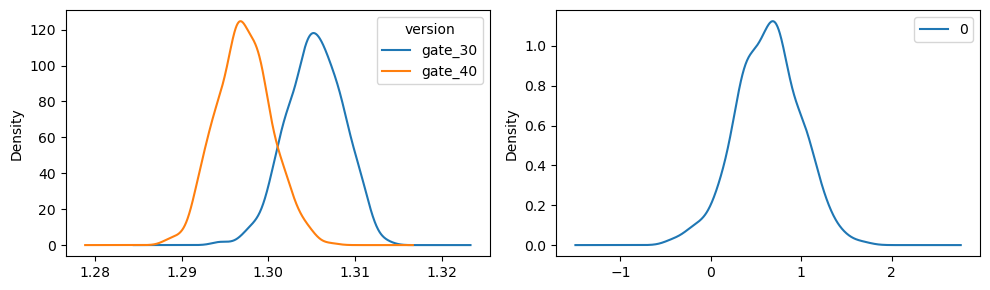

In [24]:
fig, axes = plt.subplots(1, 2)
mean_lst = []
for i in range(500):
     mean_lst.append(new.sample(frac=1, replace=True).groupby('version')[['retention_1', 'retention_7']].mean().sum(axis = 1))
df = pd.DataFrame(mean_lst)
df.plot(kind = 'density', ax = axes[0], figsize = (10,3))

diff_retention = pd.DataFrame([(i[0] - i[1])/i[1]*100 for i in mean_lst])
diff_retention.plot(kind = 'density', ax = axes[1], figsize = (10,3))

print('Probability that retention was higher when the gate is 30 : {}'.format((diff_retention>0).mean()))
plt.tight_layout()
plt.show()

The plots show that setting the gate at level 30 leads to a significantly higher degree of retention compared to level 40, which may indicate that the earlier (but not too early) the players face an enforced break, the higher the probability that the players enjoy the game.
#### 3. Gate setting in differnent retention groups

In [25]:
def group_count(df, col, sample_num):
    count_lst = []
    for i in range(sample_num):
        count_lst.append(df.sample(frac=1, replace=True).groupby('version')[col].count())
    return pd.DataFrame(count_lst)

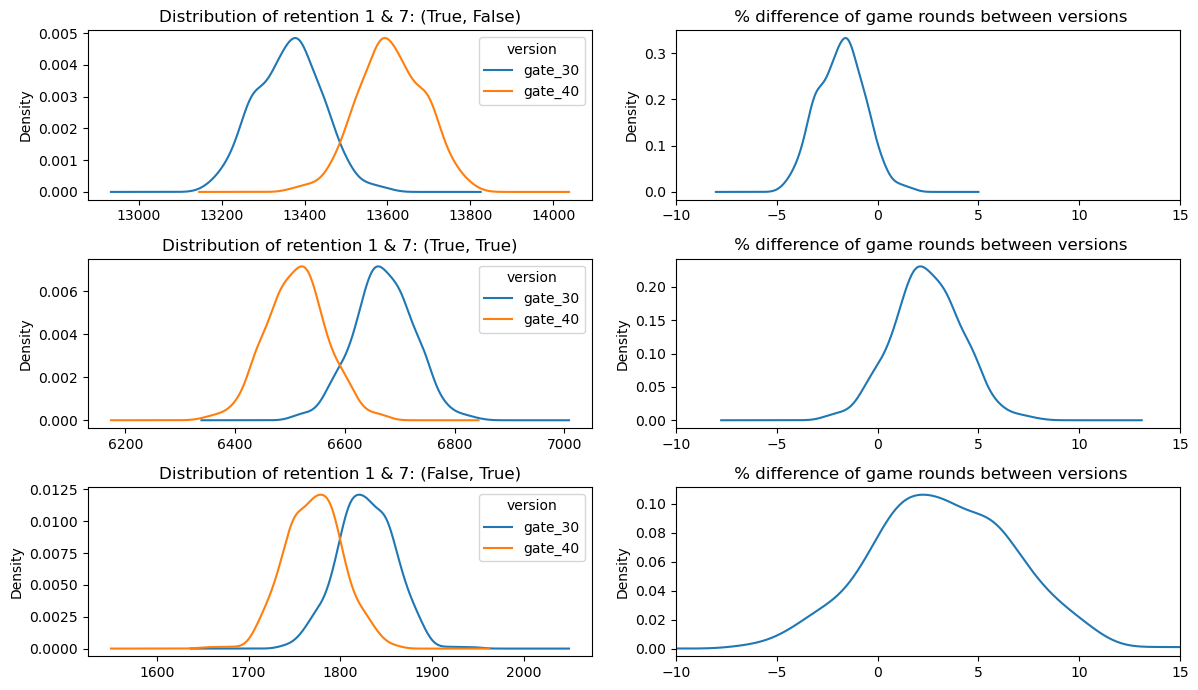

Probability that game rounds was higher when the gate is 30 in retention 1 & 7 is (True, False): 0.058
Probability that game rounds was higher when the gate is 30 in retention 1 & 7 is (True, True): 0.922
Probability that game rounds was higher when the gate is 30 in retention 1 & 7 is (False, True): 0.832


In [26]:
fig, axes = plt.subplots(3, 2)
TF_lst = retention_percent.index
ax_lst = [axes[0,0], axes[1,0], axes[2,0]]
dif_lst = [axes[0,1], axes[1,1], axes[2,1]]
report = []
for i in range(3):
    df = retention_sector.get_group(TF_lst[i+1])
    TT_df = group_count(df, 'userid', 500)
    TT_df.plot(kind = 'density', ax = ax_lst[i], title = 'Distribution of retention 1 & 7: {}'.format(TF_lst[i+1])
               , xlabel = 'sum of game rounds', figsize = (12,7))
    TT_df['diff'] = (TT_df.gate_30-TT_df.gate_40)/TT_df.gate_40 * 100
    TT_df['diff'].plot(kind = 'density', title = ' % difference of game rounds between versions'
                , ax = dif_lst[i], figsize = (12,7), xlim = (-10,15))
    report.append('Probability that game rounds was higher when the gate is 30 in retention 1 & 7 is {}: {}'.format(TF_lst[i+1], (TT_df['diff'] > 0).mean()))
    summary_dict['Avg num of users'].extend([f'{i:.2f}' for i in TT_df.mean()[:2]])
    
plt.tight_layout()
plt.show()
print("\n".join(report))

From the above chart, it can be observed that the left graph displays the differences in player counts for various gate settings after undergoing bootstrapping with 500 iterations:
1. Group ”Retention_1 = True & Retention_7 = False“：
    It can be observed that the number of players in the gate_30 group is lower than that in the gate_40 group. The most likely % difference is around -1% to -3%, and that over 94% of the distribution is below 0%
2. Group ”Retention_1 = True & Retention_7 = True“：
    Approximately 91% of players in the gate_30 group have a higher player count compared to the gate_40 group, with a difference ranging from approximately 0% to 5%.
3. Group ”Retention_1 = False & Retention_7 = True“：
    Roughly 80% of players in the gate_30 group exhibit a higher player count compared to the gate_40 group, with a difference ranging from approximately -1% to 10%.
    
<b>Insight：</b> From a game company's perspective, the desire is for users to engage with the game continuously. In comparison, setting the gate later could potentially diminish player retention. Identifying the optimal gate setting level is thus a topic well worth analyzing.

### Conclusion

In [27]:
summary_index = [[i for i in TF_lst[1:] for j in range(2)], ['G_30', 'G_40', 'G_30', 'G_40', 'G_30', 'G_40']]
pd.DataFrame(summary_dict, index = summary_index)

Avg num of users Avg game rounds
(True, False) G_30         13361.60           49.68
              G_40         13609.40           50.04
(True, True)  G_30          6670.37          183.98
              G_40          6511.63          190.39
(False, True) G_30          1827.82           99.95
              G_40          1771.18           75.07

The above analysis examines the impact of different gate settings on two indicators: game rounds and player retention. Setting the gate at level 40 results in more game rounds, while setting the gate at level 30 leads to a higher retention. 

In light of the comprehensive analysis of both indicators, I have concluded that the order of importance for the retention groups is as follows: (True, True), (False, True), (True, False), (False, False). Notably, game rounds in group (True, False) are lower than (False, True), potentially suggesting that players in this group lost interest in the game at an early stage and engaged less with the game.

From a corporate perspective, there is a desire for players to sustain engagement with the game. Therefore, I believe that retention holds greater significance. As indicated by the aforementioned analysis, it is evident that setting the gate at level 30 leads to a higher retention rate among players, despite a lower frequency of gameplay compared to setting the gate at level 40.

Here are some suggestions:
1. For the players who quit the game in the early stage: We can do more analysis on the players who ended the game early, such as questionnaire, to better understand the reasons.
2. For gate setting: The optimal gate setting experiment can be conducted  in order to make greater success.
3. For loyal players: We should strongly focus on building lasting relationships. To understanding player needs and responding proactively, here's some strategies:Player-Centric Approach,Community Building, Personalization,Events and Challenges and so on.
4. For potential targets: It is also important to find out where the target audiences are by using customer segmentation, Market Research,Content Strategy and so on.

The following psychological phenomenon can explain why setting the gate early can lead players to be more willing to engage in the game:<b>Hedonic adaptation </b>, also called the "hedonic treadmill," refers to people's tendency to revert to a baseline level of happiness after positive or negative events, indicating habituation to life changes and maintaining a stable level of happiness over time. As a result, players may eventually get bored if the game matain a consistent level. Conversely, strategically prompting breaks from the game could potentially extend the sense of enjoyment.